# Grover's algorithm

In this notebook, we are going to implement Grover's algorithm using Qiskit. 

We will start by defining a function that, given the quantum registers, creates the initial part of the circuit

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer, execute

import numpy as np

def init_grover(q):

    circ = QuantumCircuit(q) 

    n = len(q)
    
    circ.x(n-1) # The qubit that receives the oracle output must be set to |1>
    for i in range(n):
        circ.h(q[i])
    
    circ.barrier()
    
    return circ

ModuleNotFoundError: ignored

Now, we define a function for the diffusion operator on $q$ 

In [ ]:
def diffuser(q):
    
    circ = QuantumCircuit(q) 
    
    # Diffusion operator
    
    n = circ.num_qubits
    
    for i in range(n-1):
        circ.h(q[i])
        
    for i in range(n-1):
        circ.x(q[i])
        
    # To implement a multicontrolled Z we use a multicontrolled Z rotation
    
    mcz = QuantumCircuit(q, name = 'cZ')
    if(n>2):
        mcz.mcrz(np.pi,q[0:n-2],q[n-2])
    else:
        mcz.z(q[0]) # If there is only input qubit for the oracle, we don't have controls 
    
    circ.append(mcz.to_instruction(),q)
    
    for i in range(n-1):
        circ.x(q[i])

    for i in range(n-1):
        circ.h(q[i])

    circ.barrier()
    
    return circ

To test it out, we are going to define a function that implements an oracle for a boolean function that only returns 1 when the input is all ones

In [ ]:
def oracle_ones(q):

    # We will use a multicontrolled X gate 
    
    circ = QuantumCircuit(q)
    
    n = len(q)
    
    circ.mcx(q[0:n-1],q[n-1])
    
    return circ

Now, we define a function that constructs the complete circuit given the number of iterations, the number of qubits and the oracle. We also add a parameter to select whether we want measurements or not

In [ ]:
def grover(n, oracle, it = 10, measurement = True):
    
    q = QuantumRegister(n, name = 'q') # create the quantum register
    if(measurement):
        c = ClassicalRegister(n-1,name='c') # we only measure the qubits that are input to the oracle
        circ = QuantumCircuit(q,c) # create the circuit
    else:
        circ = QuantumCircuit(q) # Circuit without measurements
    
    circ.append(init_grover(q),q) # add the initial part
    
    for _ in range(it): # add repetitions of oracle plus diffusion operator
        circ.append(oracle(q),q)
        circ.append(diffuser(q),q)
        
    if(measurement):  # Measurements
        circ.measure(q[0:n-1],c)
            
        
    return circ

We are going to check the behaviour of the algorithm starting with a simple case: when we have one marked element out of four (two input qubits), we can find it with just one iteration

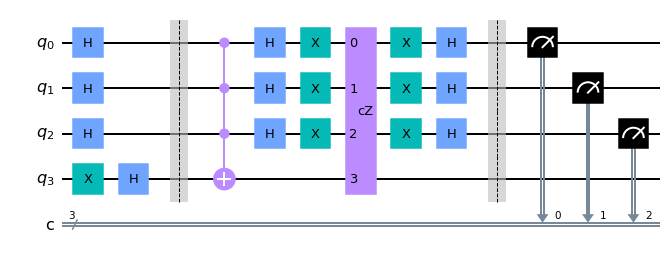

In [ ]:
n = 4

circ_grover = grover(n,oracle_ones,1)
circ_grover.decompose().draw(output = 'mpl')

In [ ]:
backend = Aer.get_backend('qasm_simulator')
job = execute(circ_grover, backend)
counts = job.result().get_counts()
print(counts)

{'101': 37, '001': 29, '110': 36, '100': 34, '000': 27, '010': 30, '011': 25, '111': 806}


Now, we are going to see the evolution of the probability of finding a marked element when the number of iterations changes. We will consider four input qubits and a number of iterations from 0 to 20.

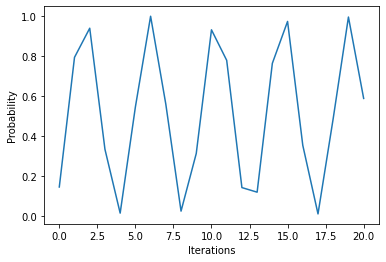

In [ ]:
import matplotlib.pyplot as plt

n = 4
max_it = 21
shots = 1000
backend = Aer.get_backend('qasm_simulator')
target=(n-1)*'1'    # The marked element as a string, to retrieve its probability

prob = [0.0]*max_it

for it in range(max_it):
    circ_grover2 = grover(n,oracle_ones,it)
    job = execute(circ_grover2, backend, shots = shots)
    counts = job.result().get_counts()
    if target in counts.keys():
        prob[it]=counts[target]/shots 
    else:
        prob[it] = 0 # Element not found

plt.plot(range(max_it),prob)
plt.xlabel('Iterations')
plt.ylabel('Probability')
plt.show()
        

As we can see, for the integer that is the closest to $\frac{\pi}{4}\sqrt{2^{n-1}}$, which is 2 for $n=4$ and 3 for $n=5$, the probability of finding the marked element is high.

<h3>2x2 Sudoku</h3>
The problem is presented in <a href="https://qiskit.org/textbook/ch-algorithms/grover.html#5.-Solving-Sudoku-using-Grover's-Algorithm-">QISkit tutorial on Grover's algorithm</a> (and at the end of this notebook).

Here an alternative solution for this problem:

In [ ]:
def oracle_sudoku(q,out=None):
    
    if out is None:
        circ = QuantumCircuit(q)
    else:
        circ = QuantumCircuit(q,out)
    
    nout = circ.num_qubits -1  #index for output

    cond_list = [[0,3], [1,2], [0,1,2], [0,1,3], [0,2,3], [1,2,3]]

    for cond in cond_list:
        circ.mcx(cond, nout)
            
    return circ

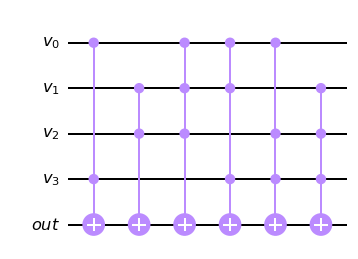

In [ ]:
q = QuantumRegister(4, name='v')
o = QuantumRegister(1,name='out')

qc = oracle_sudoku(q,o)
qc.draw('mpl')

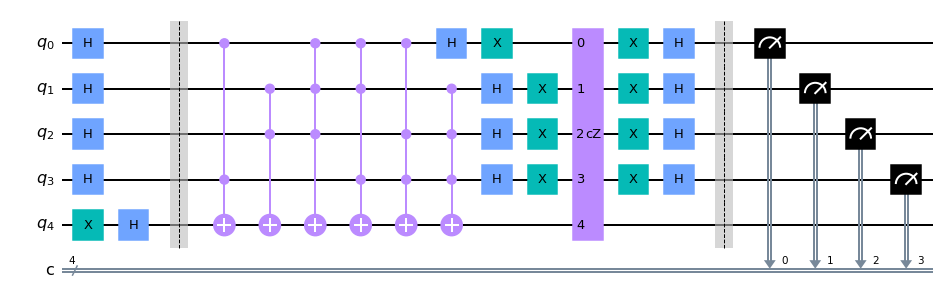

In [ ]:
n = 5

circ_sudoku = grover(n,oracle_sudoku,1)
circ_sudoku.decompose().draw(output = 'mpl')

{'1000': 26, '1010': 10, '0101': 15, '0010': 21, '0000': 18, '1011': 23, '0100': 17, '1100': 8, '1110': 23, '0110': 404, '0011': 13, '0001': 18, '0111': 19, '1101': 10, '1111': 11, '1001': 388}


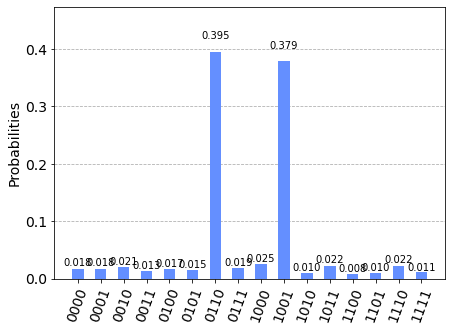

In [ ]:
from qiskit.visualization import plot_histogram
backend = Aer.get_backend('qasm_simulator')
job = execute(circ_sudoku, backend)
counts = job.result().get_counts()
print(counts)
plot_histogram(counts)

<h3>2x2 Sudoku solution from QISkit tutorial</h3>

In [ ]:
clause_list = [[0,1],
               [0,2],
               [1,3],
               [2,3]]

def XOR(qc, a, b, output):
    qc.cx(a, output)
    qc.cx(b, output)

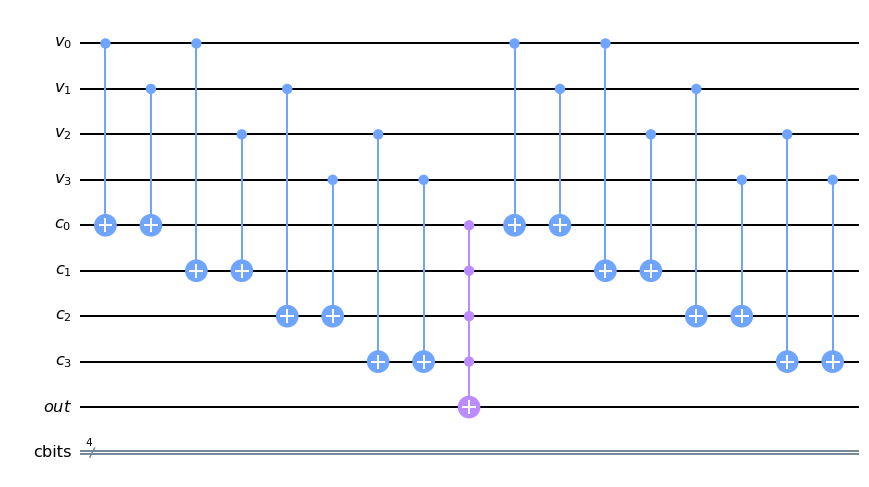

In [ ]:
var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(4, name='c')
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(4, name='cbits')
qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)

def sudoku_oracle(qc, clause_list, clause_qubits):
    # Compute clauses
    i = 0
    for clause in clause_list:
        XOR(qc, clause[0], clause[1], clause_qubits[i])
        i += 1

    # Flip 'output' bit if all clauses are satisfied
    qc.mct(clause_qubits, output_qubit)

    # Uncompute clauses to reset clause-checking bits to 0
    i = 0
    for clause in clause_list:
        XOR(qc, clause[0], clause[1], clause_qubits[i])
        i += 1

sudoku_oracle(qc, clause_list, clause_qubits)
qc.draw('mpl')

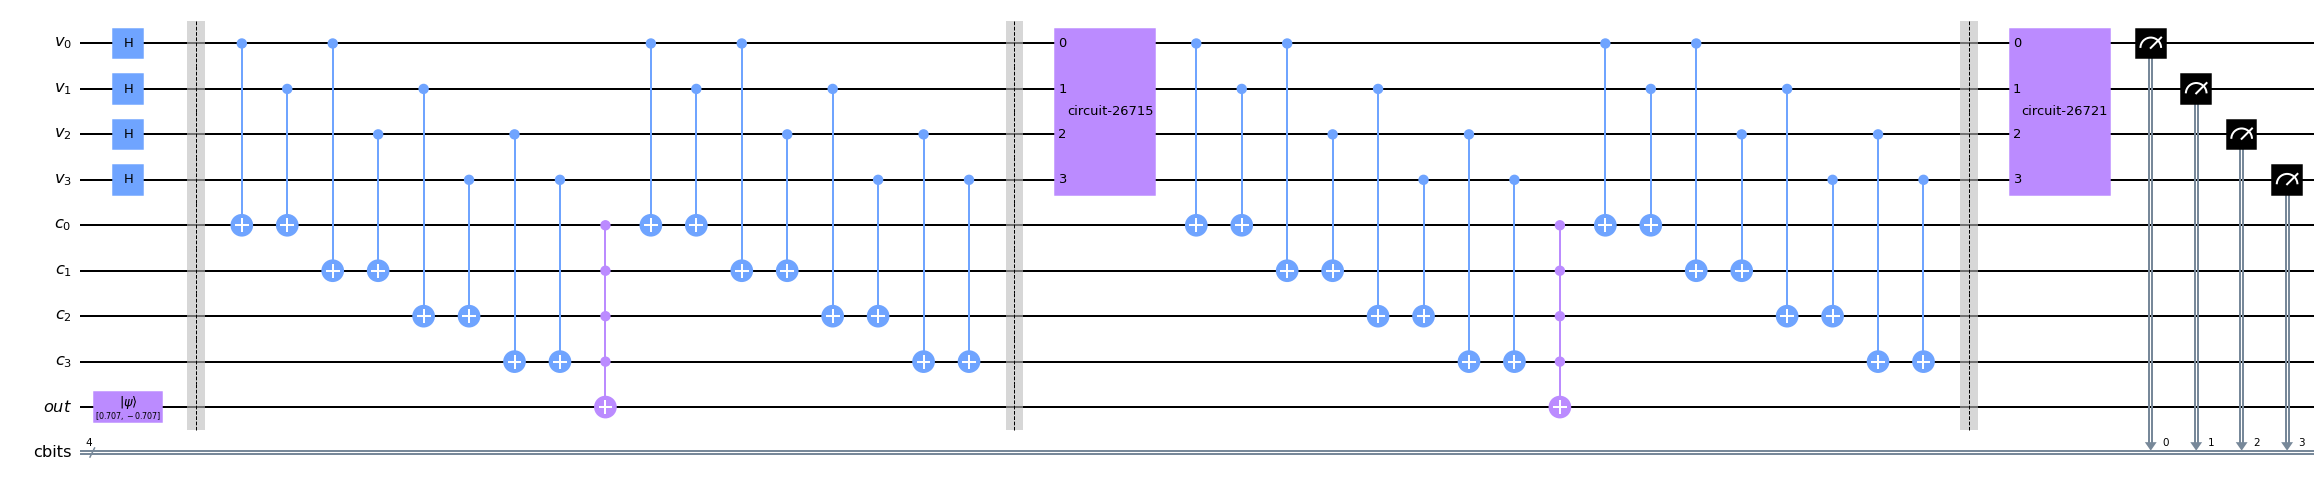

In [ ]:
var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(4, name='c')
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(4, name='cbits')
qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)

# Initialize 'out0' in state |->
qc.initialize([1, -1]/np.sqrt(2), output_qubit)

# Initialize qubits in state |s>
qc.h(var_qubits)
qc.barrier()  # for visual separation

## First Iteration
# Apply our oracle
sudoku_oracle(qc, clause_list, clause_qubits)
qc.barrier()  # for visual separation
# Apply our diffuser
qc.append(diffuser(var_qubits), [0,1,2,3])

## Second Iteration
sudoku_oracle(qc, clause_list, clause_qubits)
qc.barrier()  # for visual separation
# Apply our diffuser
qc.append(diffuser(var_qubits), [0,1,2,3])

# Measure the variable qubits
qc.measure(var_qubits, cbits)

qc.draw('mpl',fold=-1)


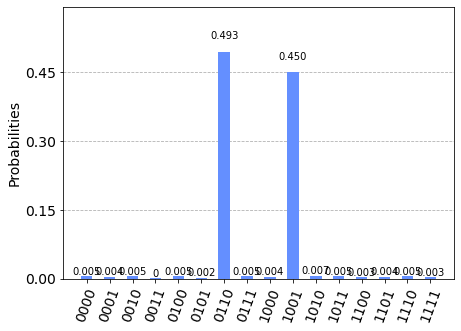

In [ ]:
from qiskit import transpile, assemble
aer_simulator = Aer.get_backend('aer_simulator')
transpiled_qc = transpile(qc, aer_simulator)
qobj = assemble(transpiled_qc)
result = aer_simulator.run(qobj).result()
plot_histogram(result.get_counts())